#DYNAMICAL MASS PROJECT

### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
from astropy.io import fits


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [3]:
# Constants:
#units also mentioned
from astropy import constants as const
from astropy import units as u

H0 = 70* u.km/u.s/u.Mpc # Hubble constant in SI unit that is in kilometre per second per megaparsec
print(H0)
c_to_kms=const.c.to(u.km/u.s) # Speed of light in km/s
print(c_to_kms)
G=const.G.to(u.Mpc * u.km**2 / u.s**2 / u.Msun)  # Gravitational constant in Mpc⋅(km/s)^2⋅M_sun⁻¹
print(G)
q0= -0.534  # Deceleration parameter (assumed from Planck fit)

70.0 km / (Mpc s)
299792.458 km / s
4.300917270036279e-09 km2 Mpc / (solMass s2)


Read the csv data into the python using the method below

In [6]:
df = pd.read_csv('Skyserver_SQL6_20_2025 5_07_17 PM.csv',header=1) # Data downloaded from SDSS. header=1 as we start reading data from the 2nd row
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      139 non-null    float64
 1   ra         139 non-null    float64
 2   dec        139 non-null    float64
 3   photoz     139 non-null    float64
 4   photozerr  139 non-null    float64
 5   specz      139 non-null    float64
 6   speczerr   139 non-null    float64
 7   proj_sep   139 non-null    float64
 8   umag       139 non-null    float64
 9   umagerr    139 non-null    float64
 10  gmag       139 non-null    float64
 11  gmagerr    139 non-null    float64
 12  rmag       139 non-null    float64
 13  rmagerr    139 non-null    float64
 14  obj_type   139 non-null    int64  
dtypes: float64(14), int64(1)
memory usage: 16.4 KB


In [7]:
df.head()

,objid,ra,dec,photoz,photozerr,specz,speczerr,proj_sep,umag,umagerr,gmag,gmagerr,rmag,rmagerr,obj_type
0,1.240000e+18,257.82458,64.133257,0.079193,0.022867,0.082447,0.000017,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3
1,1.240000e+18,257.82458,64.133257,0.079193,0.022867,0.082466,0.000014,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3
2,1.240000e+18,257.83332,64.126043,0.091507,0.014511,0.081218,0.000021,8.011259,20.22848,0.072019,18.38334,0.007763,17.46793,0.005828,3
3,1.240000e+18,257.85137,64.173247,0.081102,0.009898,0.079561,0.000022,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3
4,1.240000e+18,257.85137,64.173247,0.081102,0.009898,0.079568,0.000019,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3


In [8]:
for columns in df.columns:
  print(columns)

objid
ra
dec
photoz
photozerr
specz
speczerr
proj_sep
umag
umagerr
gmag
gmagerr
rmag
rmagerr
obj_type


### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [9]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df #there is only 1 object id so thats why only 1 row

,objid,specz,ra,dec,proj_sep
0,1.240000e+18,0.081047,257.82458,64.133257,8.347733


In [10]:
averaged_df.describe()['specz']
#count,mean,std,min,25%,50%,75% values are taken from the above single row table
#count=1 as there is only 1 row.

,specz
count,1.000000
mean,0.081047
std,NaN
min,0.081047
25%,0.081047
50%,0.081047
75%,0.081047
max,0.081047


To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group.

Find the mean, standard deviation and limits of the redshift from the data

In [11]:
import numpy as np

#Mean and std of the averaged specz values
mean_specz = df['specz'].mean()
std_specz = df['specz'].std()
# Computing the 3-sigma limits
lower_limit = mean_specz - 3 * std_specz      #Lower limit=μ−3σ
upper_limit = mean_specz + 3 * std_specz      #Upper limit=μ+3σ


print(f"Mean redshift: {mean_specz:.5f}")
print(f"Standard deviation: {std_specz:.5f}")
print(f"3-sigma lower limit: {lower_limit:.5f}")
print(f"3-sigma upper limit: {upper_limit:.5f}")


Mean redshift: 0.08105
Standard deviation: 0.00950
3-sigma lower limit: 0.05255
3-sigma upper limit: 0.10954


You can also use boxplot to visualize the overall values of redshift

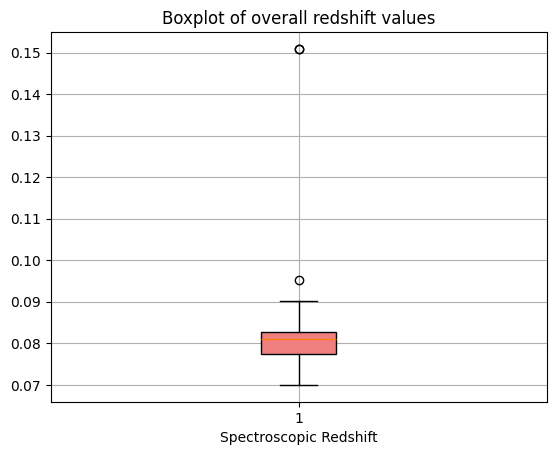

In [12]:
import matplotlib.pyplot as plt
# Boxplot of overall redshift value
plt.boxplot(df['specz'], patch_artist=True,boxprops=dict(facecolor='lightcoral'))
plt.title('Boxplot of overall redshift values')
plt.xlabel('Spectroscopic Redshift')
plt.grid(True)
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

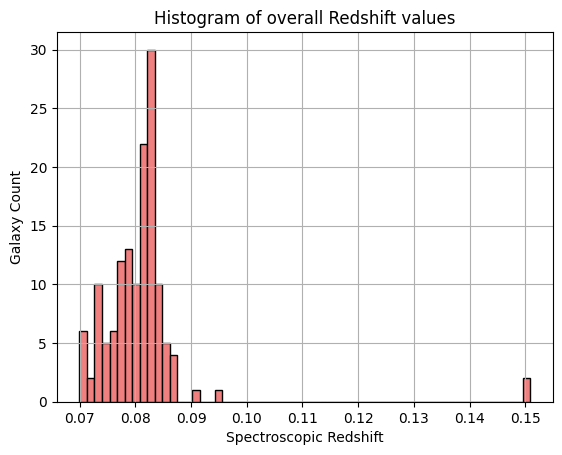

In [13]:
# Histogram of redshifts
plt.hist(df['specz'], color='lightcoral', edgecolor='black',bins=60)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Galaxy Count')
plt.title('Histogram of overall Redshift values')
plt.grid(True)
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [14]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
filtered_df = df[(df['specz'] >= lower_limit) & (df['specz'] <= upper_limit)]
print("Original count:", len(df))
print("Filtered count:", len(filtered_df)) #only 2 values were not in the range of upper limit and lower limit

Original count: 139
Filtered count: 137


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift

In [15]:
filtered_df['velocity'] = filtered_df['specz'] * c_to_kms
filtered_df['velocity'].head()

/tmp/ipython-input-15-1625550812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['velocity'] = filtered_df['specz'] * c_to_kms


,velocity
0,24717.081720
1,24722.783773
2,24348.666769
3,23851.808736
4,23853.802356


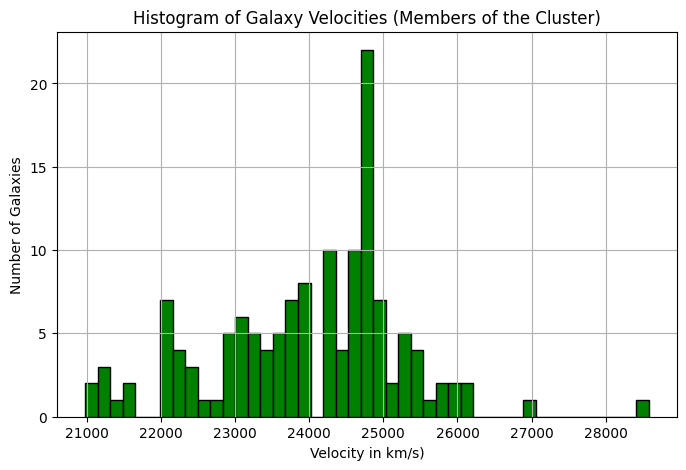

In [16]:
#plot the velocity column created as hist
import matplotlib.pyplot as plt

# Plot histogram of galaxy velocities
plt.figure(figsize=(8, 5))
plt.hist(filtered_df['velocity'], bins=45, color='green', edgecolor='black')
plt.xlabel('Velocity in km/s)')
plt.ylabel('Number of Galaxies')
plt.title('Histogram of Galaxy Velocities (Members of the Cluster)')
plt.grid(True)
plt.show()


use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [17]:
import numpy as np
from astropy.constants import c
import astropy.units as u

#Calculation of mean redshift of the cluster(z_cluster)
z_cluster = filtered_df['specz'].mean()
print(z_cluster)

z = filtered_df['specz'] #redshift of the individual galaxy

numerator = (1 + z)**2 - (1 + z_cluster)**2 #numerator of relativistic Doppler formula
denominator = (1 + z)**2 + (1 + z_cluster)**2 # denominator of relativistic Doppler formula

filtered_df['velocity_dispersion'] = c_to_kms * (numerator/denominator) # velocity dispersion ( v ) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula
filtered_df['velocity_dispersion'].head()

0.08002739656934307


/tmp/ipython-input-17-2395977292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['velocity_dispersion'] = c_to_kms * (numerator/denominator) # velocity dispersion ( v ) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula


,velocity_dispersion
0,670.963582
1,676.231250
2,330.417516
3,-129.470206
4,-127.623517


In [18]:
sigma_v = filtered_df['velocity_dispersion'].std() #standard deviation of the velocity dispersion of cluster
print(f"Velocity dispersion (σ): {sigma_v:.2f} km/s")

Velocity dispersion (σ): 1202.58 km/s


Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [19]:
filtered_df['velocity_dispersion'].describe()

,velocity_dispersion
count,137.000000
mean,-2.392825
std,1202.576295
min,-2803.471718
25%,-763.070775
50%,248.411265
75%,767.132350
max,4217.366753


In [20]:
print(f"The value of the cluster redshift = {z_cluster:.4f}")

The value of the cluster redshift = 0.0800


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



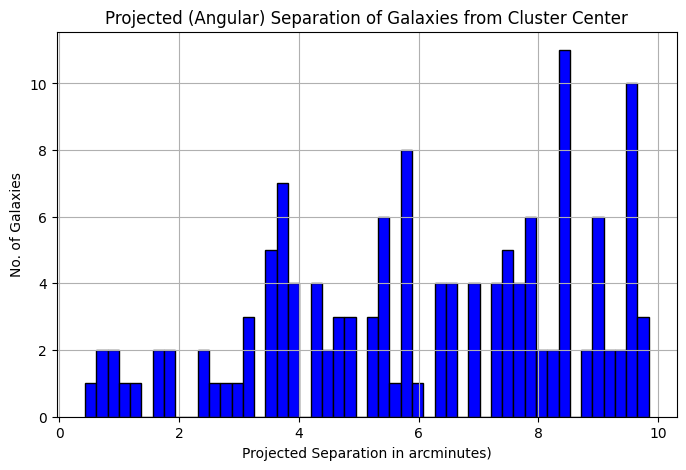

In [21]:
#Plot histogram for proj sep column

# Histogram of projected angular separation
plt.figure(figsize=(8, 5))
plt.hist(filtered_df['proj_sep'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Projected Separation in arcminutes)')
plt.ylabel('No. of Galaxies')
plt.title('Projected (Angular) Separation of Galaxies from Cluster Center')
plt.grid(True)
plt.show()


### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [22]:
r = (c_to_kms * z_cluster / H0) * (1 - (z_cluster / 2) * (1 + q0))#co-moving distance
DA = r / (1 + z_cluster)  # angular diameter distance
theta_arcmin = filtered_df['proj_sep'].max()  # e.g., 9.8 arcmin
theta_rad = np.deg2rad(theta_arcmin / 60)    # converting to radians
diameter_mpc = DA * theta_rad #angular diameter (in arcminutes) into physical diameter
print(f"Co-moving distance (r): {r:.2f}")
print(f"Angular diameter distance (D_A): {DA:.2f}")
print(f"Physical diameter of cluster: {diameter_mpc.value:.4f} Mpc (for θ = {theta_arcmin} arcmin)")

Co-moving distance (r): 336.35 Mpc
Angular diameter distance (D_A): 311.42 Mpc
Physical diameter of cluster: 0.8918 Mpc (for θ = 9.844518658 arcmin)


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [26]:
# Constants
solar_mass = u.Msun     # 1 solar mass in kg
#Velocity dispersion (σ) in m/s
sigma = sigma_v * 1000* u.m / u.s  # converting to m/s
G_si = const.G
#Radius in meters (half of physical diameter)
radius_m = (diameter_mpc / 2)  # 1 Mpc = 3.086e22 meters
radius_m_in_meters = radius_m.to(u.m)
#Dynamical mass calculation
M_dyn_kg = (3 * sigma**2 * radius_m_in_meters) / G_si

#Dynamic mass calculation
M_dyn_solar = M_dyn_kg.to(solar_mass)
print(f"Cluster radius: {radius_m_in_meters:.2e}")
print(f"Dynamical Mass: {M_dyn_solar:.2e}")

Cluster radius: 1.38e+22 m
Dynamical Mass: 4.50e+14 solMass


#LUMINOUS MASS CALCULATION

In [27]:
# Solar magnitude in r-band
M_sun_r = 4.65

#Computing luminosity distance in parsecs
DL_Mpc = (1 + filtered_df['specz']) * r  # r from earlier step
DL_pc = DL_Mpc * 1e6

#Computing absolute magnitude
filtered_df['M_r'] = filtered_df['rmag'] - 5 * np.log10(DL_pc) + 5

#Computing luminginosity in solar units
filtered_df['L_r'] = 10 ** (-0.4 * (filtered_df['M_r'] - M_sun_r))

#Estimation of luminous mass
#Typical M/L for elliptical galaxies ≈ 3 (can vary)
M_L_ratio = 3
filtered_df['luminous_mass'] = filtered_df['L_r'] * M_L_ratio

#Total luminous mass calculation
M_luminous_total = filtered_df['luminous_mass'].sum()
print(f"Total luminous mass: {M_luminous_total:.2e} solar masses")

Total luminous mass: 1.07e+13 solar masses


/tmp/ipython-input-27-553261645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['M_r'] = filtered_df['rmag'] - 5 * np.log10(DL_pc) + 5
/tmp/ipython-input-27-553261645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['L_r'] = 10 ** (-0.4 * (filtered_df['M_r'] - M_sun_r))
/tmp/ipython-input-27-553261645.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th